# Airline On-Time Performance Data
## by Barnabas Ifebude

## Investigation Overview

In this investigation, I wanted to look at the features in the airline on-time performance dataset that could be used to predict flight delays. The main focus was on the arrival delay, departure delay, airport and airlines.

## Dataset Overview

The data consists of 118,914,458 US commerical flights information betwee Oct 1988 and April 2008, with 29 features including the flight date, departure & arrival time, departure & arrival delays in minutes among other features.

In [1]:
# import all packages and set plots to be embedded inline
import pandas as pd
import seaborn as sns
from zipfile import ZipFile
import matplotlib.pyplot as plt

%matplotlib inline

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Extract all files from the zipped file.
zipped_file = 'datasets/dataverse_files.zip'
path = 'datasets/data'

with ZipFile(zipped_file) as zf:
    zf.extractall(path)
    

# Import functions needed for data processing
%run functions.py

# Call function to create flights, airports, carriers and plane_data tables 
create_tables()

# Call function to read csv files and insert into the database tables
read_data()

# Call function to add a computed date column to the flights table
add_date_column()

In [3]:
# Query to load arr_delay into a dataframe
query = """
    SELECT arr_delay 
    FROM flights 
    WHERE arr_delay IS NOT NULL"""

df = query_to_df(query, optimize=True)

Memory usage before optimization 1.73 GB
Memory usage after optimization 1.08 GB
Total Run Time: 2 minutes


## Distribution of Flight Delays

Flight delays (arr_delay) in the dataset take on a very large range of values, from about \-1500 at the lowest, to about 2500 at the highest. Plotted on a logarithmic scale, the distribution of flight delay takes on a unimodal shape.

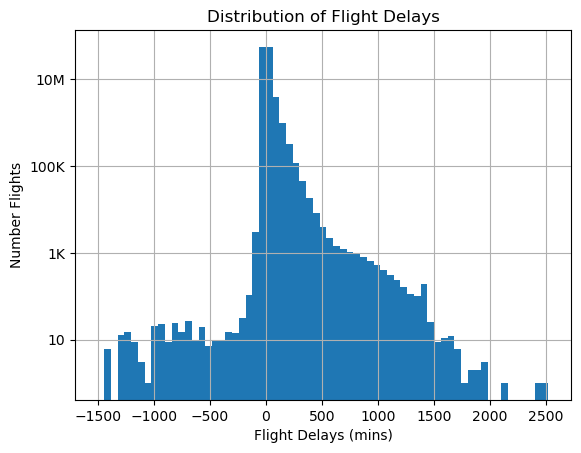

In [5]:
# Most the flight delays were between -50 and 50, 
# making most of the bins invisible, let apply a log scale on the y-axis
bins = np.arange(-1500, 2500 + 60, 60)
df.arr_delay.hist(bins=bins)
plt.title('Distribution of Flight Delays')
plt.xlabel('Flight Delays (mins)')
plt.ylabel('Number Flights (log)')
plt.yscale('log')
plt.yticks([10, 1000, 100000, 10000000], ['10', '1K', '100K', '10M']);

In [6]:
# Query to load arr_delay into a dataframe
query = """
    SELECT dep_delay 
    FROM flights 
    WHERE dep_delay IS NOT NULL"""

df = query_to_df(query, optimize=True)

Memory usage before optimization 1.74 GB
Memory usage after optimization 1.09 GB
Total Run Time: 2 minutes


## Distribution of Airport Delays

Airport delays (dep_delay) just like the flight delays in the dataset take on a very large range of values, from about \-1500 at the lowest, to about 2500 at the highest. Plotted on a logarithmic scale, the distribution of airport delay takes on a unimodal shape.

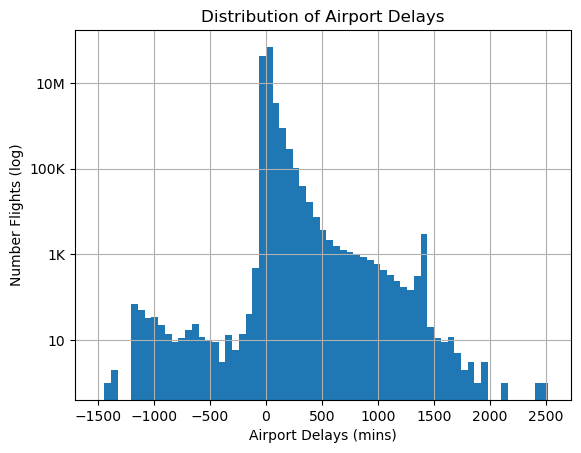

In [7]:
# Most the airport delays were between -50 and 50 just like the flight delays, 
# making most of the bins invisible, let apply a log scale on the y-axis
bins = np.arange(-1500, 2500 + 60, 60)
df.dep_delay.hist(bins=bins)
plt.title('Distribution of Airport Delays')
plt.xlabel('Airport Delays (mins)')
plt.ylabel('Number Flights (log)')
plt.yscale('log')
plt.yticks([10, 1000, 100000, 10000000], ['10', '1K', '100K', '10M']);

In [8]:
query = """
    SELECT dep_delay, arr_delay 
    FROM flights
    WHERE dep_delay >= 15 AND
        arr_delay >= 15 AND
        dep_delay IS NOT NULL AND
        arr_delay IS NOT NULL
    """

delays = query_to_df(query, optimize=True)

Memory usage before optimization 0.35 GB
Memory usage after optimization 0.17 GB
Total Run Time: 1 minutes


## Arrival delay vs. Departure delay

There appears to be strong positive relationship between arrival and departure delays.

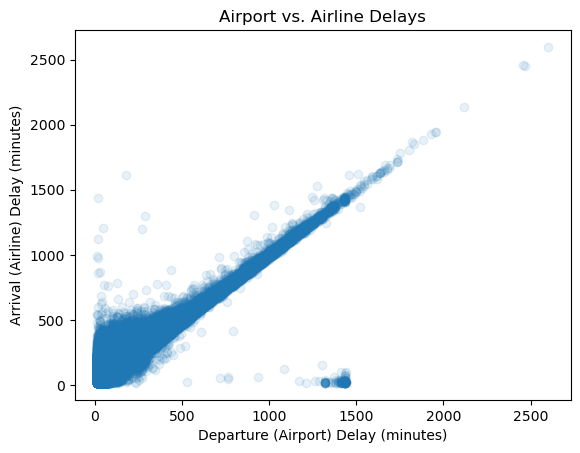

In [9]:
plt.scatter(data=delays, x='dep_delay', y='arr_delay', alpha=0.1);
plt.title('Airport vs. Airline Delays')
plt.xlabel('Departure (Airport) Delay (minutes)')
plt.ylabel('Arrival (Airline) Delay (minutes)');

In [10]:
query = """
    SELECT id,
        origin, 
        unique_carrier, 
        date, 
        dep_delay,
        arr_delay
    FROM flights
    WHERE dep_delay >= 15 AND
        arr_delay >= 15 AND
        dep_delay IS NOT NULL AND
        arr_delay IS NOT NULL AND
        origin in ('ORD', 'ATL', 'DFW', 'LAX', 'PHX')
    """

airport_delays = query_to_df(query, optimize=True)

airport_delays['date'] = pd.to_datetime(airport_delays['date'])
airport_delays = airport_delays.set_index('date')

Memory usage before optimization 0.74 GB
Memory usage after optimization 0.28 GB
Total Run Time: 1 minutes


## Departure delay by Airports

The median flight delay at the Chicago O'Hare International airport (ORD) appears to be the highest across the top 5 airports.

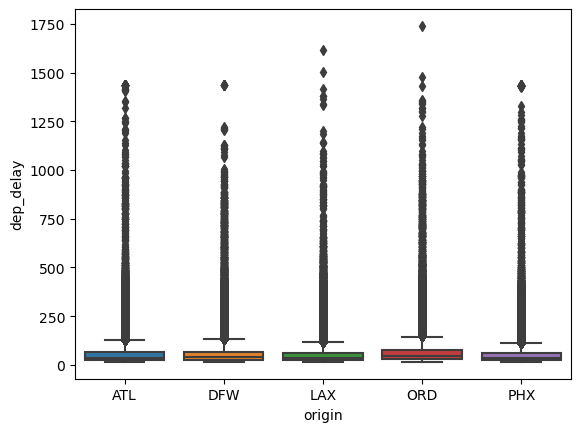

In [11]:
sns.boxplot(data=airport_delays, x='origin', y='dep_delay');

## Delayed Flights Trend by Airport by Year

Generally, the trend of the number of delayed flights per airport per year is steadily increasing with major airport and across the entire industry. However, there was a steep decline in flight delays after 9/11 attack.

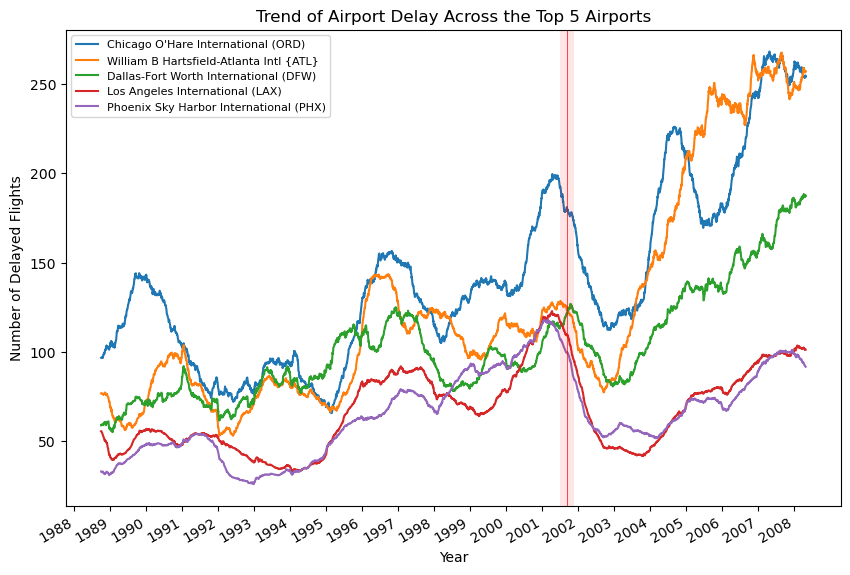

In [29]:
ord = airport_delays.groupby(['origin','date']).count()['arr_delay']['ORD'].rolling(365).mean()
atl = airport_delays.groupby(['origin','date']).count()['arr_delay']['ATL'].rolling(365).mean()
dfw = airport_delays.groupby(['origin','date']).count()['arr_delay']['DFW'].rolling(365).mean()
lax = airport_delays.groupby(['origin','date']).count()['arr_delay']['LAX'].rolling(365).mean()
phx = airport_delays.groupby(['origin','date']).count()['arr_delay']['PHX'].rolling(365).mean()

ticks = [ '{}-01-01'.format(year) for year in range(1988, 2009)]

plt.figure(figsize=(10, 7))

ord.plot(label='Chicago O\'Hare International (ORD)')
atl.plot(label='William B Hartsfield-Atlanta Intl {ATL}')
dfw.plot(label='Dallas-Fort Worth International (DFW)')
lax.plot(label='Los Angeles International (LAX)')
phx.plot(label='Phoenix Sky Harbor International (PHX)')
plt.legend(fontsize=8)
plt.axvline('2001-09-11', linewidth=0.5, color='red') # 9/11 mark
plt.axvline('2001-09-11', linewidth=10, color='red', alpha=.1);
plt.xticks(ticks, [tick[:4] for tick in ticks]);

plt.title('Trend of Airport Delay Across the Top 5 Airports')
plt.xlabel('Year')
plt.ylabel('Number of Delayed Flights');

## Arrival vs Departure Delay by Airport

Across the major airports, there appears to be a strong relationship between arrival and depart delay.

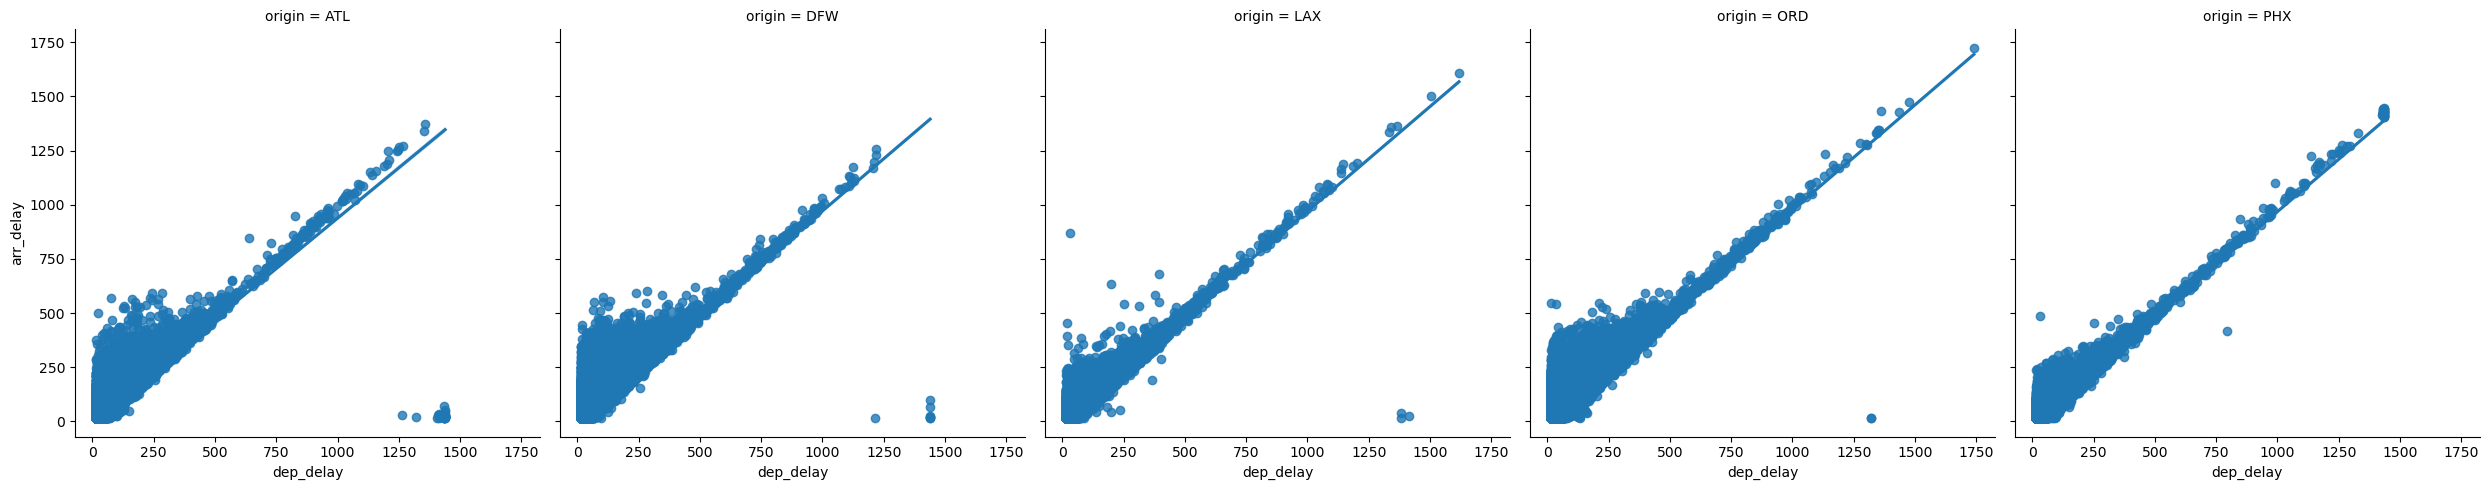

In [30]:
sns.lmplot(data=airport_delays, 
           x='dep_delay', y='arr_delay', col='origin');

In [ ]:
!jupyter nbconvert <Part_II_Filename>.ipynb --to slides --post serve --no-input --no-prompt